# ResNet18 with `fastai` on NVIDIA Jetson

NVIDIA Jetson devices provide powerful AI inference capabilities at the edge, and with the right setup, you can efficiently run deep learning models like ResNet18 using the fastai library. This guide walks you through installing necessary dependencies, setting up PyTorch and fastai, and running inference using a ResNet18 model.

## Installation

This guide provides step-by-step instructions for setting up an [NVIDIA® Jetson Orin Nano™ Developer Kit](https://developer.nvidia.com/embedded/learn/jetson-orin-nano-devkit-user-guide/index.html) for deep learning with PyTorch, torchvision, and fastai. The setup will be performed via a terminal from a host machine connected via USB or serial connection.

### Software and Package Versions

- **JetPack** - 6.2 (also compatible with 6.1)  
- **CUDA** - 12.6  
- **Python** - 3.10  
- **cuSPARSELt** - 0.7.0  
- **torch** - 2.5.0a0+872d972e41 ([NVIDIA wheel](https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch)).  
- **torchvision** - 0.20.0 (built from source)  
- **spacy** - 3.7.2  
- **fastai** - 2.7.18  

### Tips - WIFI connection and IP address

If your Jetson device is controlled via serial connection, here are some instructions to connect to Wifi using `nmcli`:

1. Check available WiFi networks: `nmcli device wifi list`  
2. Connect to a WiFi network: `nmcli device wifi connect "SSID_NAME" password "YOUR_PASSWORD"`  
3. Verify the Connection: `nmcli connection show --active`

Note: If encountering unauthorized error, add `sudo` before these commands.

After connecting to WIFI, the user can retrieve the IP address assigned to the Jetson device. Check the active connections with the command in step 3, which should output their names, UUIDs, types, and devices. Notice the device of the WIFI (type) connection and use it with the command `ip a show <DEVICE_NAME>`. From another device, e.g., host machine, that also connects to this WIFI, verify the connection to Jetson by using `ping` on this IP address.

### Step 1 - Installing JetPack and SDK Components

The Jetson device must be flashed with JetPack, which includes the Jetson Linux OS and necessary GPU computing libraries such as CUDA and cuDNN. Follow the official [NVIDIA JetPack installation guide](https://developer.nvidia.com/embedded/jetpack-sdk-62) for instructions. Ensure that firmware version is updated to 36+ for JetPack > 6.

To flash Jetson Orin Nano, install [NVIDIA SDK Manager](https://docs.nvidia.com/sdk-manager/index.html) on a Linux host machine and follow the setup steps. During flashing, select Jetson SDK Components to install CUDA toolkit in the [second step](https://docs.nvidia.com/sdk-manager/install-with-sdkm-jetson/index.html#step-02-review-components-and-accept-licenses). If CUDA is missing post-installation, follow the JetPack [package management guide](https://docs.nvidia.com/jetson/jetpack/install-setup/index.html#package-management-tool).

CUDA installation can be verified with:
```sh
$ nvcc --version
```
or
```sh
$ nvidia-smi
```
For additional verification, compile and run a CUDA sample:
```sh
# Clone suitable version for testing CUDA 12.6 
$ git clone -b v12.5 https://github.com/NVIDIA/cuda-samples.git
$ cd cuda-samples/Samples/1_Utilities/deviceQuery
$ make
$ ./deviceQuery
```

### Step 2 - Installing PyTorch and torchvision

Jetson devices use integrated GPUs (iGPUs) while default CUDA backend of PyTorch is optimized for discrete GPUs (dGPUs). To enable PyTorch with GPU acceleration on Jetson, follow the custom installation available in [NVIDIA instructions](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform/index.html) and [NVIDIA forums](https://forums.developer.nvidia.com/t/pytorch-for-jetson/72048). The supporting package torchvision also has to be built from source on the Jetson device.

#### Installing cuSPARSELt

For PyTorch versions 24.06+ (see [Compatibility Matrix](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform-release-notes/pytorch-jetson-rel.html#pytorch-jetson-rel)), cuSPARSELt is required. Install it with these [instructions](https://developer.nvidia.com/cusparselt-downloads) by selecting Linux OS, aarch64-jetson architecture, and Ubuntu distribution:
```sh
$ wget https://developer.download.nvidia.com/compute/cusparselt/0.7.0/local_installers/cusparselt-local-tegra-repo-ubuntu2204-0.7.0_1.0-1_arm64.deb
$ sudo dpkg -i cusparselt-local-tegra-repo-ubuntu2204-0.7.0_1.0-1_arm64.deb
$ sudo cp /var/cusparselt-local-tegra-repo-ubuntu2204-0.7.0/cusparselt-*-keyring.gpg /usr/share/keyrings/
$ sudo apt-get update
$ sudo apt-get -y install libcusparselt0 libcusparselt-dev
```

#### Installing PyTorch

Create a virtual environment (recommended):

```sh
$ sudo apt-get install virtualenv
$ cd <target-directory>
$ python3 -m virtualenv -p python3 <venv-name>
$ source <venv-name>/bin/activate
```

Install PyTorch with a custom wheel built by NVIDIA:  

1. Check compatibility from [NVIDIA Jetson PyTorch matrix](https://docs.nvidia.com/deeplearning/frameworks/install-pytorch-jetson-platform-release-notes/pytorch-jetson-rel.html).  
2. Select suitable wheel from [list of released wheels](https://developer.download.nvidia.com/compute/redist/jp/) by selecting `v$JP_VERSION` (JetPack version) > `pytorch` > `$PYT_VERSION ... .whl` (PyTorch version).  
3. Install with pip - 
```sh
$ pip3 install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v$JP_VERSION/pytorch/$PYT_VERSION ... .whl
```

In this tutorial, PyTorch version 2.5 for JetPack 6.1 (still compatible with 6.2) will be installed with:
```sh
$ pip3 install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl
```

Verify with Python Terminal:
```sh
$ python3
>>> import torch
>>> print(torch.__version__)
>>> print('CUDA available: ' + str(torch.cuda.is_available()))
>>> print('cuDNN version: ' + str(torch.backends.cudnn.version()))
>>> a = torch.cuda.FloatTensor(2).zero_()
>>> print('Tensor a = ' + str(a))
>>> b = torch.randn(2).cuda()
>>> print('Tensor b = ' + str(b))
>>> c = a + b
>>> print('Tensor c = ' + str(c))
```

#### Installing torchvision

torchvision must be built from source:
```sh
$ sudo apt-get install libjpeg-dev zlib1g-dev libpython3-dev libopenblas-dev libavcodec-dev libavformat-dev libswscale-dev
$ git clone --branch release/0.$VERSION https://github.com/pytorch/vision torchvision
$ cd torchvision
$ export BUILD_VERSION=0.$VERSION.0
$ python3 setup.py install --user # remove --user if installing in virtualenv
```

In this tutorial, torchvision version 0.20.0 is installed by replacing `$VERSION` with 20.

Verify with Python terminal:
```sh
$ python3
>>> import torchvision
>>> print(torchvision.__version__)
```

#### Troubleshooting

Here are some known issues and tips for troubleshooting:

- If a warning about numpy version is show, downgrade to numpy with `pip install 'numpy<2'`  
- If you encounter this runtime error - `RuntimeError: operator torchvision::nms does not exist`, follow the instructions in [this NVIDIA forum post](https://forums.developer.nvidia.com/t/pytorch-and-torvision-version-issue-runtimeerror-operator-torchvision-nms-does-not-exist/312446). Specifically, install the pre-compiled binaries of `torch` and `torchvision`:

```sh
$ pip install http://jetson.webredirect.org/jp6/cu126/+f/5cf/9ed17e35cb752/torch-2.5.0-cp310-cp310-linux_aarch64.whl#sha256=5cf9ed17e35cb7523812aeda9e7d6353c437048c5a6df1dc6617650333049092
$ pip install http://jetson.webredirect.org/jp6/cu126/+f/5f9/67f920de3953f/torchvision-0.20.0-cp310-cp310-linux_aarch64.whl#sha256=5f967f920de3953f2a39d95154b1feffd5ccc06b4589e51540dc070021a9adb9
```

### Step 3 - Installing fastai

Ensure PyTorch and torchvision were installed first to avoid version conflicts, note that fastai version 2.7.18 requires torch < 2.6. Install fastai and dependencies:

```sh
$ pip install spacy==3.7.2
$ pip install fastai
```

**Troubleshooting**: spacy version 3.7.2 should be installed first because building wheel for spacy version 3.8.3 can fail on this architecture.

### Step 4 - (Optional) Setting up Jupyter Notebook for Remote Access via SSH tunnel
To use a remote server running from a Jetson device, first check IP address of Jetson device with Linux command:   

```sh
$ ip a
```  

Look for an IP address similar to 192.168.x.x or 10.x.x.x.

(Optional) Control Jetson terminal via SSH. Log in with Jetson username (user of Linux OS running on Jetson) and enter password when prompted.  

```sh
$ ssh <jetson-username>@<jetson-ip>
```

Install Jupyterlab or Jupyter Notebook on Jetson terminal (or SSH session):

```sh
$ pip install jupyterlab
$ pip isntall notebook
```

Start server from Jetson terminal (or SSH session):

```sh
$ jupyter notebook --no-browser --port=8888 --ip=0.0.0.0
```  

From your local PC, forward port 8888 using SSH:

```sh
ssh -N -L 8888:localhost:8888 <jetson-username>@<jetson-ip>
```

And access running Jupyter server with localhost: `http://localhost:8888/`

## ResNet18 on Imagenette dataset

Now that your environment is ready, let's train a ResNet18 model on Imagenette-320, a smaller dataset derived from ImageNet, but with 320x320 resolution images.

In a Python script or Jupyter Notebook, import the necessary fastai libraries:

In [ ]:
#| eval: false
from fastai.vision.all import *

The Imagenette-320 dataset can be downloaded easily using `untar_data()` function. This dataset contains separate training and validation sets:

In [ ]:
#| eval: false
path = untar_data(URLs.IMAGENETTE_320, data=Path.cwd()/'data')
train_files = get_image_files(path/'train')
val_files = get_image_files(path/'val')

print(f"Training set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")

Training set size: 9469
Validation set size: 3925


Use `ImageDataLoaders.from_folder()` to quickly load images and split them into training and validation sets. Set   `item_tfms` to resize all images to 224×224, ensuring compatibility with ResNet models, and `batch_tfms` to apply ImageNet normalization for consistency with the pretrained ResNet input distribution.

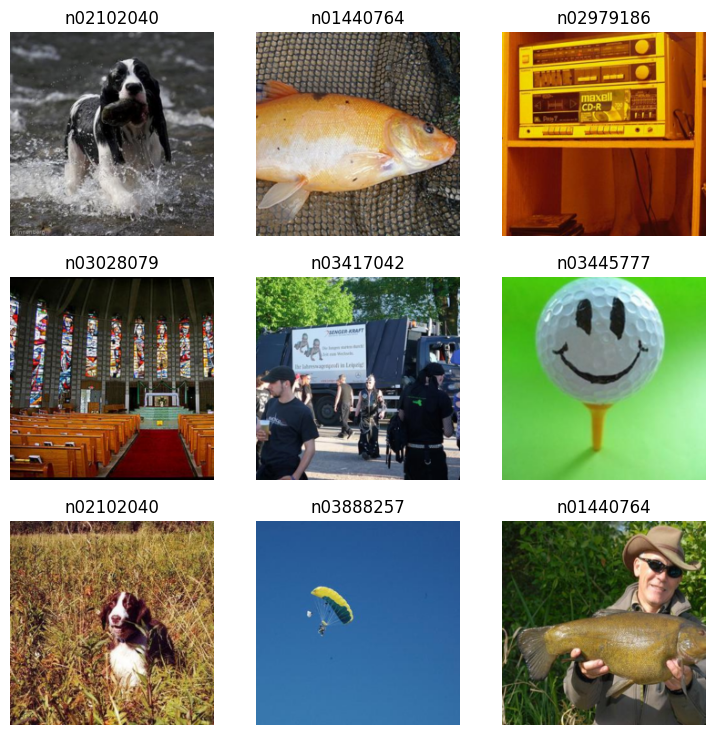

In [ ]:
#| eval: false
dls = ImageDataLoaders.from_folder(
    path, 
    valid='val',  # Use 'val' folder for validation set
    item_tfms=Resize(224),  # Resize images to 224x224
    batch_tfms=Normalize.from_stats(*imagenet_stats),  # Normalize using ImageNet stats
)
dls.show_batch()

Create a **ResNet18** model using `vision_learner()`, which sets up the architecture for image classification. Use `accuracy` as the main metrics and load a pretrained model. Enable transfer learning with `fine_tune(epochs)` to adapt to the current dataset.

In [ ]:
#| eval: false
learn = vision_learner(dls, resnet18, metrics=accuracy, pretrained=True)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.246164,0.051711,0.985732,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.092586,0.058606,0.982930,01:13


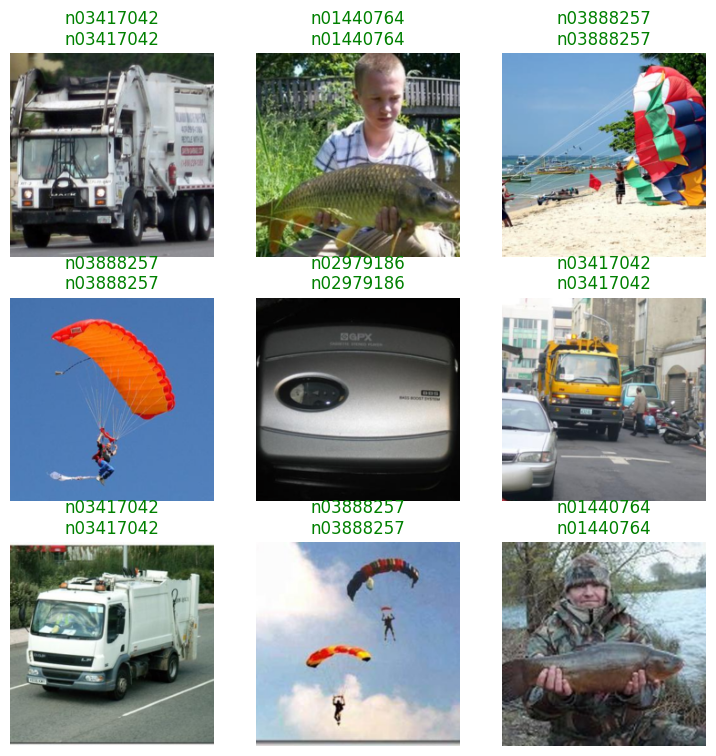

In [ ]:
#| eval: false
learn.show_results()

fastai also provides the `Interpretation` class to further analyze model performance by extracting its predictions and identify misclassified images. For instance, the function `plot_top_losses()` of this class can help visualize the most significant errors.

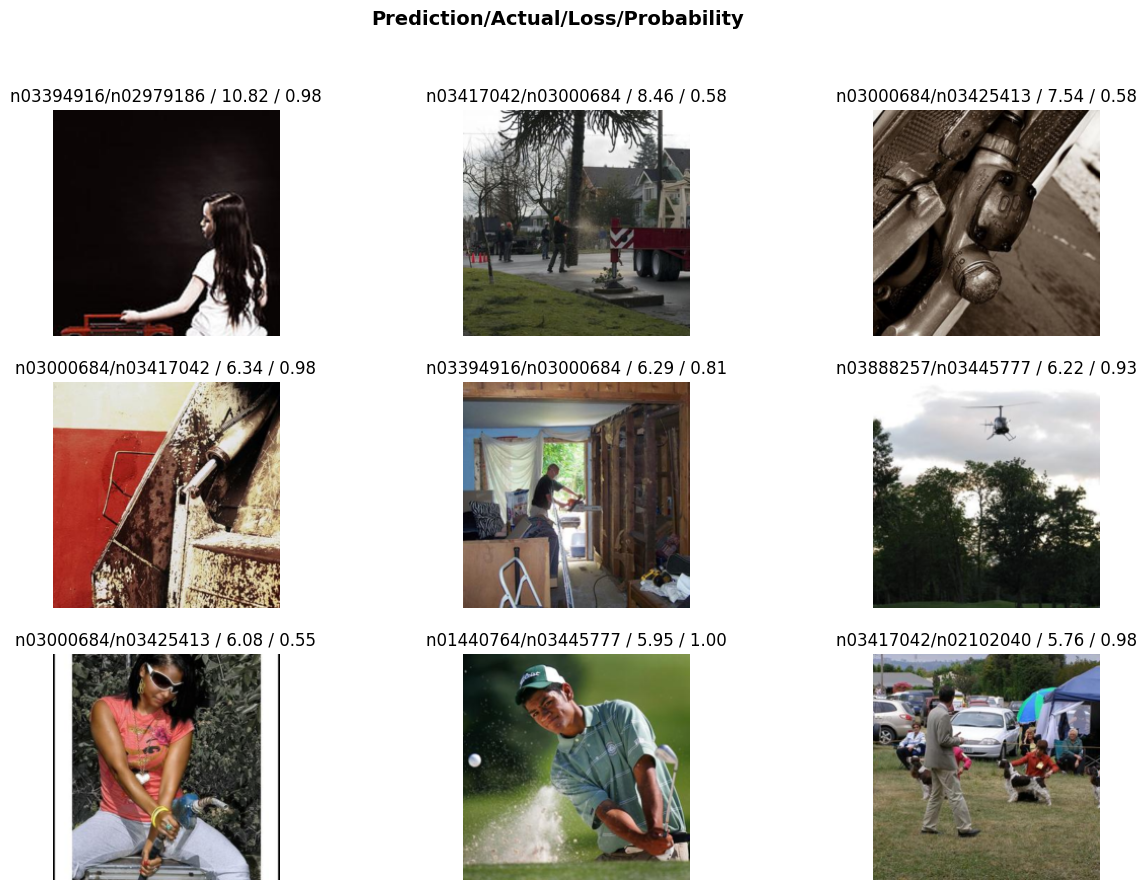

In [ ]:
#| eval: false
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

The model then can be used to make predictions for new images:

/home/jetson/jetson-examples/fastai/data/imagenette2-320/train/n03888257/n03888257_457.JPEG


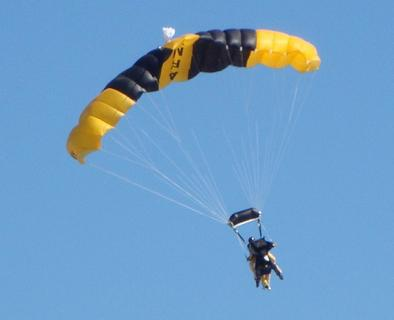

In [ ]:
#| eval: false
print(train_files[0])  # Image label is the name of its parent folder
Image.open(train_files[0])

In [ ]:
#| eval: false
pred, pred_idx, probs = learn.predict(train_files[0])  # Predict the label of the first image in the training set
print(f'Prediction: {pred}, Probability: {probs[pred_idx]:.4f}')

Prediction: n03888257, Probability: 1.0000


The model can also be saved with:

In [ ]:
#| eval: false
learn.path = Path.cwd() / 'models' # Save model in 'models' folder
learn.export('resnet18.pkl') 

To reload the model in another session:

In [ ]:
#| eval: false
learn = load_learner(Path.cwd() / 'models' / 'resnet18.pkl')